# Importing Libraries

In [13]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

import time

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.0


# Preparing Training and Test Sets

In [14]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [15]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
        self.image_dirs = image_dirs
        self.transform = transform
        
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        
        return self.transform(image), self.class_names.index(class_name)

# Decide GPU or CPU

In [16]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU


# Image Transformations

In [17]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [18]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [19]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [20]:
batch_size = 5
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 563
Num of test batches 18


# Data Visualization

In [21]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize = (8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green' if preds[i] == labels[i] else 'red'

        plt.xlabel(f'{class_names[int(labels[i].cpu().numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].cpu().numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

# Creating the Model

In [22]:
alexnet = torchvision.models.alexnet(pretrained=True)

In [23]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
# alexnet.classifier._modules['6'] = torch.nn.Linear(4096, 3)
alexnet.classifier[6] = torch.nn.Linear(alexnet.classifier[6].in_features, 3)
alexnet = alexnet.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters(), lr = 3e-5)

In [25]:
def show_preds():
    alexnet.eval()
    images, labels = next(iter(dl_test))
    images, labels = images.to(device), labels.to(device)
    outputs = alexnet(images)
    print(outputs.size())
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

torch.Size([5, 3])


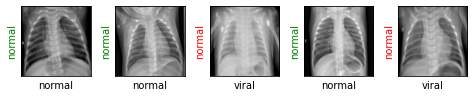

In [26]:
show_preds()

In [27]:
accs = []
losses = []

# Training the Model

In [28]:
def train(epochs):
    tstart = time.time()
    print('starting training..')
    for e in range(epochs):
        print('='*20)
        print(f'starting epoch {e + 1}/{epochs}')
        print('=' * 20)
        train_loss = 0
        #resnet18.train()
        alexnet.train()
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            #outputs = resnet18(images)
            outputs = alexnet(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('evaluating at step', train_step)
                acc = 0.
                val_loss = 0.
                #resnet18.eval()
                alexnet.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    images, labels = images.to(device), labels.to(device)
                    #outputs = resnet18(images)
                    outputs = alexnet(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).cpu().numpy())
                val_loss /= (val_step + 1)
                acc /= len(test_dataset)
                accs.append(acc)
                losses.append(val_loss)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                #resnet18.train()
                alexnet.train()
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')
    
    ttrain = time.time() - tstart
    print('Training time: %d seconds' %(ttrain))
        

starting training..
starting epoch 1/1
evaluating at step 0
Val loss: 1.1296, Acc: 0.3667
torch.Size([5, 3])


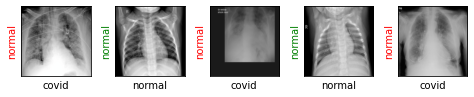

evaluating at step 20
Val loss: 0.5310, Acc: 0.8222
torch.Size([5, 3])


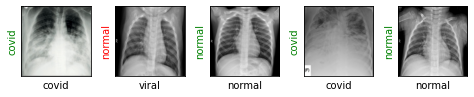

evaluating at step 40
Val loss: 0.3248, Acc: 0.8889
torch.Size([5, 3])


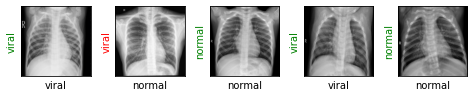

evaluating at step 60
Val loss: 0.2139, Acc: 0.9333
torch.Size([5, 3])


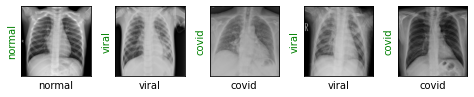

evaluating at step 80
Val loss: 0.1424, Acc: 0.9667
torch.Size([5, 3])


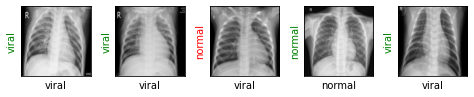

evaluating at step 100
Val loss: 0.0931, Acc: 1.0000
torch.Size([5, 3])


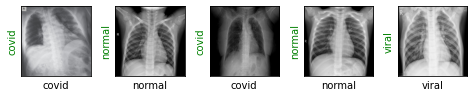

evaluating at step 120
Val loss: 0.1069, Acc: 0.9444
torch.Size([5, 3])


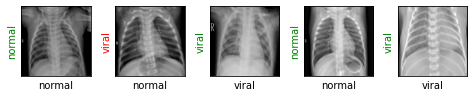

evaluating at step 140
Val loss: 0.2211, Acc: 0.8778
torch.Size([5, 3])


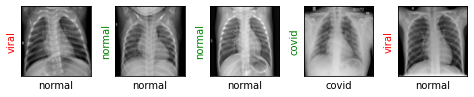

evaluating at step 160
Val loss: 0.1310, Acc: 0.9333
torch.Size([5, 3])


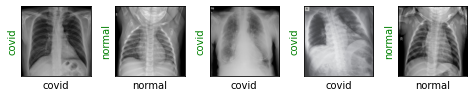

evaluating at step 180
Val loss: 0.1202, Acc: 0.9778
torch.Size([5, 3])


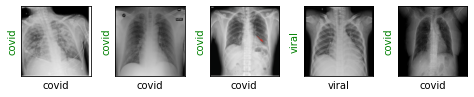

evaluating at step 200
Val loss: 0.0334, Acc: 1.0000
torch.Size([5, 3])


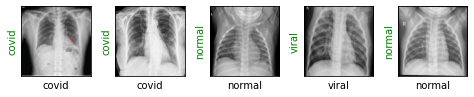

evaluating at step 220
Val loss: 0.4356, Acc: 0.8667
torch.Size([5, 3])


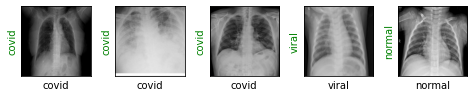

evaluating at step 240
Val loss: 0.0711, Acc: 0.9889
torch.Size([5, 3])


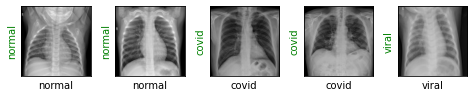

evaluating at step 260
Val loss: 0.2736, Acc: 0.8222
torch.Size([5, 3])


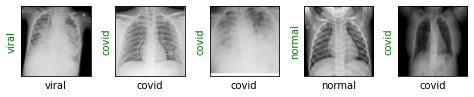

evaluating at step 280
Val loss: 0.1429, Acc: 0.9667
torch.Size([5, 3])


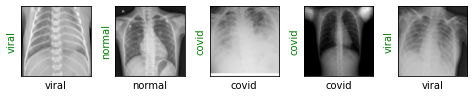

evaluating at step 300
Val loss: 0.1017, Acc: 0.9556
torch.Size([5, 3])


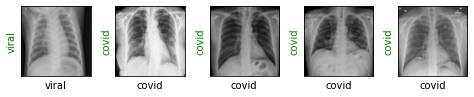

evaluating at step 320
Val loss: 0.0730, Acc: 0.9667
torch.Size([5, 3])


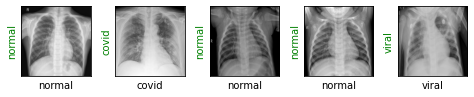

evaluating at step 340
Val loss: 0.0954, Acc: 0.9556
torch.Size([5, 3])


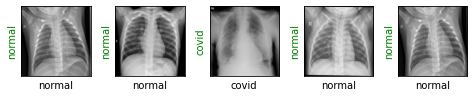

evaluating at step 360
Val loss: 0.0698, Acc: 0.9667
torch.Size([5, 3])


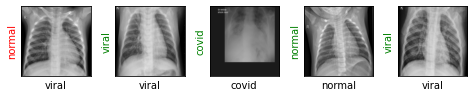

evaluating at step 380
Val loss: 0.0461, Acc: 0.9889
torch.Size([5, 3])


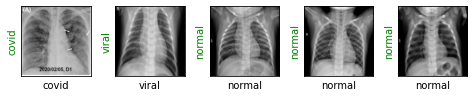

evaluating at step 400
Val loss: 0.0906, Acc: 0.9444
torch.Size([5, 3])


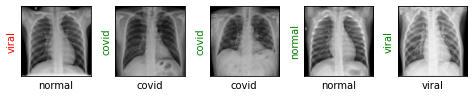

evaluating at step 420
Val loss: 0.2089, Acc: 0.9222
torch.Size([5, 3])


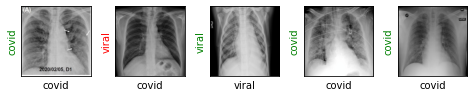

evaluating at step 440
Val loss: 0.0790, Acc: 0.9667
torch.Size([5, 3])


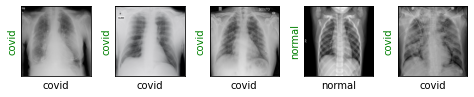

evaluating at step 460
Val loss: 0.1001, Acc: 0.9556
torch.Size([5, 3])


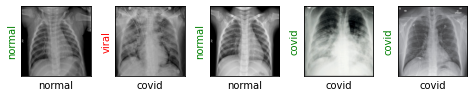

evaluating at step 480
Val loss: 0.1368, Acc: 0.9444
torch.Size([5, 3])


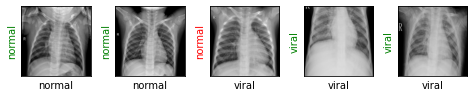

evaluating at step 500
Val loss: 0.1012, Acc: 0.9444
torch.Size([5, 3])


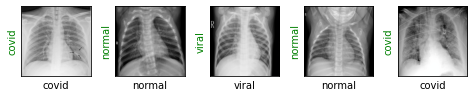

evaluating at step 520
Val loss: 0.0745, Acc: 0.9778
torch.Size([5, 3])


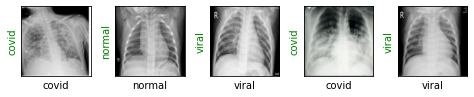

evaluating at step 540
Val loss: 0.0661, Acc: 0.9778
torch.Size([5, 3])


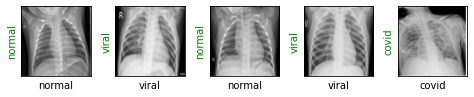

evaluating at step 560
Val loss: 0.0590, Acc: 0.9889
torch.Size([5, 3])


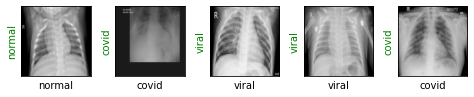

Training loss: 0.2087
Training time: 148 seconds


In [29]:
train(epochs = 1)

# Some visualizations

torch.Size([5, 3])


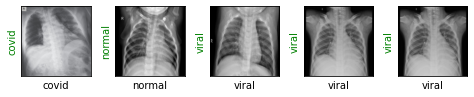

In [30]:
show_preds()

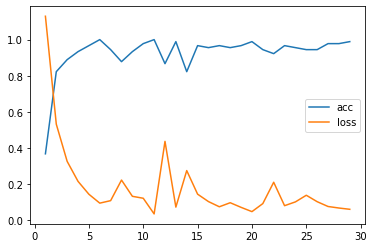

In [31]:
steps = list(range(1, 30))
plt.plot(steps, accs, label = 'acc')
plt.plot(steps, losses, label = 'loss')
plt.legend()
plt.show()